National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Natural Language Processing

Final Project: Question Answering

Student: Andrei Batyrov (Fall2022)

Date: 5-Mar-2024

##### Table of Contents

[Description](#description)

1. [Data Analysis](#data-analysis)

2. [Pre-trained embeddings as features for classifier](#pre-trained)

3. [Fine-tune BERT](#fine-bert)

4. [Summary & results analysis](#summary)

In [1]:
# Essential import
import gc
import json
import string
from pathlib import Path
import numpy as np
import pandas as pd
from gensim import models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
import re
nltk.download('punkt')
seed = 13
torch.manual_seed(seed=seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device = }')

device = device(type='cuda')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def plot_pr_curve(precisions, recalls, y_true, y_pred, title):
    ''' 
    Plot Precision-Recall curve and show confusion matrix.
    '''
    
    plt.figure(figsize=(5, 5))
    auc_ = auc(recalls, precisions)
    plt.plot(recalls, precisions, color='C0', label=f'Val ({auc_:.2f})')
    plt.hlines(y_true.mean(), xmin=0.0, xmax=1.0, ls='--', color='C1', label=f'Random ({y_true.mean():.3f})')
    
    cm = pd.DataFrame(
            confusion_matrix(y_true, y_pred, labels=[1, 0]),
            columns=['Pred = 1', 'Pred = 0'],
            index=['True = 1', 'True = 0']).T
    
    # Show confusion matrix at the bottom (in the x label)
    plt.xlabel(f'Recall\n\n \
        Confusion matrix:\n{cm}\n \
        Precision = {precision_score(y_true, y_pred):.3f}\n \
        Recall = {recall_score(y_true, y_pred):.3f}\n \
        $F_{1}$-score = {f1_score(y_true, y_pred):.3f}\n \
        AUC = {auc_:.2f}\n \
        Accuracy = {accuracy_score(y_true, y_pred):.2f}', size=10, fontfamily='monospace')
    
    plt.ylabel('Precision', size=10, fontfamily='monospace')
    plt.legend(fontsize=8)
    plt.grid(lw=0.5, color='xkcd:cement')
    plt.title(f'{title}', size=10, fontfamily='monospace')
    plt.grid(lw=0.5, color='xkcd:cement');

In [3]:
def save_metrics(model_name, **metrics):
    '''
    Dump train/val loss and accuracy lists to a json file.
    '''
    with open(f'./metrics/{model_name}.json', 'w') as fh:
        json.dump(metrics, fh)

In [4]:
def load_metrics(model_name):
    '''
    Load train/val loss and accuracy lists from a json file.
    '''
    try:
        with open(f'./metrics/{model_name}.json', 'r') as fh:
            return json.load(fh)
    except:
        raise RuntimeError(f'The metrics json file not found. Was the model `{model_name}` trained?')

In [5]:
def load_model(model):
    '''
    Try to find and load our fine-tuned model.
    '''
    try:
        model.model.load_state_dict(torch.load(f'./models/{model.name}.pt'))
        model.model = model.model.to(device)
        model.is_trained = True
        print(f'Found fine-tuned model `{model.name}.pt`. Ready for inferring/testing.')
    except:
        print(f'Fine-tuned model `{model.name}` not found. Train/eval the model first.')

In [6]:
def plot_metrics(model_name: str, epochs):
    '''
    Plot model's loss and accuracy metrics obtained during train/val over the number of `epochs`.
    '''
    metrics = load_metrics(model_name)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), metrics['train_losses'], marker='s', color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_losses'], marker='s', color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), metrics['train_accs'], marker='s', color='C0', label='Train')
    plt.plot(range(1, epochs+1), metrics['val_accs'], marker='s', color='C1', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs+1))
    plt.legend()
    plt.grid(lw=0.5)
    plt.suptitle(f'Train and validation datasets metrics: {model_name}', fontsize=11)
    plt.tight_layout();

---
# <a id="description"></a>Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no. 

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "label": false,
      "idx": 123,
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.


## Detailed Task Description

In the task you should perform all the model training on `train.jsonl` data and evaluate your models on `val.jsonl`. Note that you do not need `test.jsonl`.

Use **accuracy metric** for scoring.

The solution of either BoolQ or DaNetQA should include:

### <a id="data-analysis"></a>[10%] 1. Data analysis 

* 1.1  (10%) Download the data and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary.

In [27]:
# Load data
train_data = pd.read_json('BoolQ/train.jsonl', lines=True, dtype={'label': int})
val_data = pd.read_json('BoolQ/val.jsonl', lines=True, dtype={'label': int})

In [28]:
train_data.shape, val_data.shape

((9427, 4), (3270, 4))

In [29]:
# Look at 10 random questions and passages
train_data.sample(10)

,question,passage,idx,label
8787,is there a dam on the mississippi river,List of locks and dams of the Upper Mississipp...,8787,1
3734,is it illegal to kill cardinals in texas,Northern cardinal -- The northern cardinal is ...,3734,1
2916,did chevy chase sing you can call me al,You Can Call Me Al -- Paul Simon did not like ...,2916,0
6588,does the island of puerto rico pay federal inc...,Puerto Rico -- Puerto Ricans are by law natura...,6588,0
2713,can a ship go from the great lakes to the ocean,Great Lakes Waterway -- The waterway allows pa...,2713,1
1662,is there going to be a 30th season of the simp...,The Simpsons -- Since its debut on December 17...,1662,1
1697,do the titans win in remember the titans,Remember the Titans -- While celebrating the v...,1697,1
3972,can i create my own page on wikipedia,Wikipedia:Autobiography -- Writing an autobiog...,3972,0
7269,is a graphics card the same as a video card,Video card -- A video card (also called a disp...,7269,1
8161,does silence of the lambs come before hannibal,Hannibal Lecter (franchise) -- The next adapta...,8161,1


In [30]:
# Examine target
target = 'label'

In [31]:
# Check nulls
train_data[target].isna().sum(), val_data[target].isna().sum()

(0, 0)

In [32]:
# Target distribution in train
train_data[target].value_counts(normalize=True)

label
1    0.623104
0    0.376896
Name: proportion, dtype: float64

In [33]:
# Target distribution in val
val_data[target].value_counts(normalize=True)

label
1    0.621713
0    0.378287
Name: proportion, dtype: float64

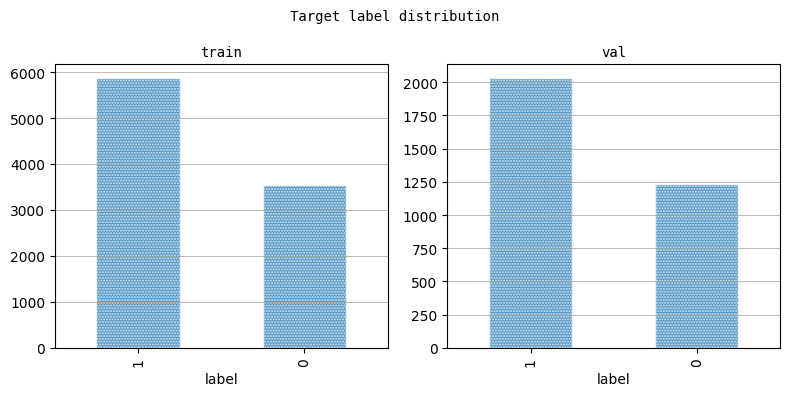

In [34]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
train_data[target].value_counts().plot.bar(alpha=0.75, edgecolor='white', color='C0', hatch='.'*6)
plt.title('train', size=10, fontfamily='monospace')
plt.grid(axis='y', lw=0.5, color='xkcd:cement');

plt.subplot(1, 2, 2)
val_data[target].value_counts().plot.bar(alpha=0.75, edgecolor='white', color='C0', hatch='.'*6)
plt.title('val', size=10, fontfamily='monospace')
plt.grid(axis='y', lw=0.5, color='xkcd:cement')
plt.suptitle('Target label distribution', size=10, fontfamily='monospace')
plt.tight_layout();

We can see that the target classes are imbalanced.

In [35]:
# Question and passage length distributions in words
train_data['question'].str.split().apply(len).describe()

count    9427.000000
mean        8.815742
std         1.318676
min         4.000000
25%         8.000000
50%         8.000000
75%         9.000000
max        21.000000
Name: question, dtype: float64

In [36]:
train_data['passage'].str.split().apply(len).describe()

count    9427.000000
mean       97.447332
std        53.598931
min        11.000000
25%        61.000000
50%        88.000000
75%       122.000000
max       758.000000
Name: passage, dtype: float64

In [37]:
val_data['question'].str.split().apply(len).describe()

count    3270.000000
mean        8.707034
std         1.166125
min         3.000000
25%         8.000000
50%         8.000000
75%         9.000000
max        17.000000
Name: question, dtype: float64

In [38]:
val_data['passage'].str.split().apply(len).describe()

count    3270.000000
mean       96.404893
std        55.026815
min        13.000000
25%        60.000000
50%        86.000000
75%       119.000000
max       817.000000
Name: passage, dtype: float64

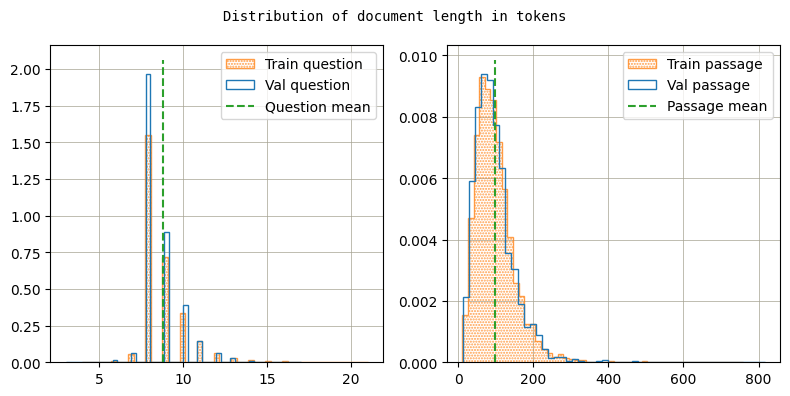

In [39]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(train_data['question'].str.split().apply(len), bins=50, density=True, color='C1', alpha=0.75, histtype='step', hatch='.'*6, label='Train question')
plt.hist(val_data['question'].str.split().apply(len), bins=50, density=True, color='C0', histtype='step', label='Val question')
plt.vlines(pd.concat([train_data['question'], val_data['question']], axis=0).str.split().apply(len).mean(), 0, plt.gca().get_ylim()[1], color='C2', ls='--', label='Question mean')
plt.legend()
plt.grid(lw=0.5, color='xkcd:cement')

plt.subplot(1, 2, 2)
plt.hist(train_data['passage'].str.split().apply(len), bins=50, density=True, color='C1', alpha=0.75, histtype='step', hatch='.'*6, label='Train passage')
plt.hist(val_data['passage'].str.split().apply(len), bins=50, density=True, color='C0', histtype='step', label='Val passage')
plt.vlines(pd.concat([train_data['passage'], val_data['passage']], axis=0).str.split().apply(len).mean(), 0, plt.gca().get_ylim()[1], color='C2', ls='--', label='Passage mean')
plt.legend()
plt.grid(lw=0.5, color='xkcd:cement')
plt.suptitle('Distribution of document length in tokens', size=10, fontfamily='monospace')
plt.tight_layout();

We can see that questions are mostly under 15 words long, and passages are under 300 words long. Train question/passage on average are equal to val question/passage. Also, there are some really long passages.

### <a id="pre-trained"></a>[40%] 2. Pre-trained embeddings as features for classifier

* 2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.

**Note:** you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

Let's take a pre-trained Word2Vec model exposing GoogleNews vectors with dimension of 300. This project is done on a Windows machine, but fastText is officially supported only on Mac OS and Linux, so, we'll use Word2Vec only.

In [40]:
w2v_model = models.KeyedVectors.load_word2vec_format(fname='../PA/Week2/GoogleNews-vectors-negative300.bin.gz', binary=True)
w2v_model

Pre-trained Word2Vec model exposes individual word embeddings. At the same time, in this assignment we deal with documents (sentences, texts). So, we need to apply some pooling to "aggregate" word embeddings in every document to eventually get embeddings not for individual words but for whole documents.

In Week2 programming assignment of the Natural Language Processing course we saw that the mean pooling was the best among min, max, mean, and sum poolings. So, let's apply the mean pooling where document vector is the mean vector of all word vectors in this document. We will implement it as a sklearn-compatible fit-transform class.

We will also need to preprocess input documents:
- lower sentences,
- tokenize sentences,
- remove punctuation.

Let's use `nltk` library for tokenization.

In [41]:
class Word2VecDocVectorizer(object):
    
    def __init__(self, model):
        self.model = model
        self.dim = self.model.vectors.shape[1]
    

    def fit(self, X, y):
        ''' Fit vectorizer '''
    
        return self
    

    def transform(self, X):
        ''' Transform X 
        X is an iterable of sentences
        Example:
        X = ['the cat sat on the mat',
             'the dog lies on the sofa']
        '''
        
        doc_embeddings = []

        for x in X:
            x_embeddings = []
            # Clean
            x = re.sub('\n', ' ', x)
            x = x.translate(str.maketrans('', '', string.punctuation))
            # Tokenize
            tokens = nltk.word_tokenize(x.lower())
            for token in tokens:
                if token in self.model:
                    x_embeddings.append(self.model[token])
            
            # Compute document embedding as the mean of all token embeddings in this document
            doc_embeddings.append(np.mean(x_embeddings or [np.zeros(self.dim)], axis=0))

        return np.array(doc_embeddings)

In [42]:
w2v_vectorizer = Word2VecDocVectorizer(w2v_model)

In [43]:
# Check
w2v_vectorizer.transform([train_data['question'][0]]).shape

(1, 300)

As expected for Word2Vec with GoogleNews pre-trained embeddings, each question is now embedded into $\mathbb{R}^{300}$.

* 2.2  (15%) Use pre-trained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

Now, we have both questions and passages, being vectorized, as features. These features can now be pipelined to a classification model. Our target is binary, so, we will use a binary classification model. Let's choose `Logistic Regression` as the baseline model in this assignment.

> Quick note: Since Word2Vec does not distinguish between questions and passages — both are just texts — we can simply concatenate these columns to produce document embeddings for the concatenated pair of one question and one passage.

In [44]:
X_train_w2v = train_data['question'] + ' ' + train_data['passage'] 
y_train_w2v = train_data[target]
X_val_w2v = val_data['question'] + ' ' + val_data['passage']
y_val_w2v = val_data[target]

In [45]:
X_train_w2v.shape, y_train_w2v.shape, X_val_w2v.shape, y_val_w2v.shape

((9427,), (9427,), (3270,), (3270,))

Fit the model and make predictions.

> Quick note: Set the hyperparameter `class_weight='balanced'`, since our target classes are imbalanced. For imbalanced classes, the accuracy metric may be misleading and be too optimistic. Fitting LogReg with this hyperparameter allows to pay more attention to the minority class. As such, the model predictions may have lower but more realistic accuracy.

In [46]:
# Train on train
pipe_w2v_lr = make_pipeline(w2v_vectorizer, LogisticRegression(class_weight='balanced', random_state=seed, n_jobs=4))
pipe_w2v_lr.fit(X_train_w2v, y_train_w2v)

Pipeline(steps=[('word2vecdocvectorizer',
                 <__main__.Word2VecDocVectorizer object at 0x0000022C3B518280>),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', n_jobs=4,
                                    random_state=13))])

In [47]:
# Test on val
y_pred_proba_class_1_val = pipe_w2v_lr.predict_proba(X_val_w2v)[:, 1]
precision_val_w2v, recall_val_w2v, _ = precision_recall_curve(y_val_w2v, y_pred_proba_class_1_val)
# Do not predict class labels to save time. Instead, classify y_proba by default threshold 0.5
y_pred_val_w2v = np.where(y_pred_proba_class_1_val >= 0.5, 1, 0)

Compute accuracy and other metrics for `Word2Vec + Logistic Regression` on val.

In [48]:
w2v_lr_acc = accuracy_score(y_val_w2v, y_pred_val_w2v)
print(f'{w2v_lr_acc:.2f}')

0.58


Since target classes are imbalanced, let's also check confusion matrix and metrics for the positive class: precision, recall, f1-score, and AUC.

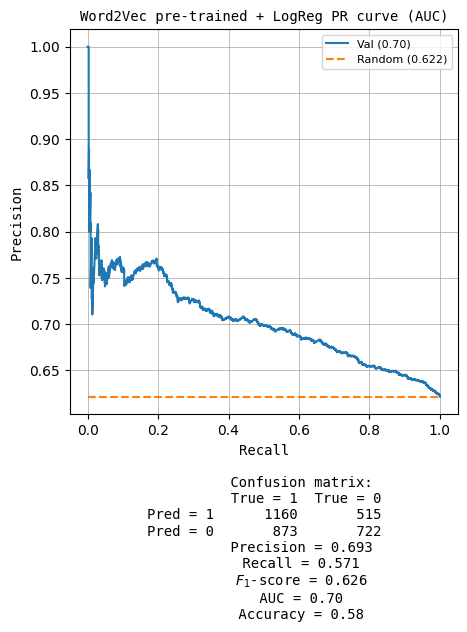

In [49]:
plot_pr_curve(precision_val_w2v, recall_val_w2v, y_val_w2v, y_pred_val_w2v, 'Word2Vec pre-trained + LogReg PR curve (AUC)')

We can see that the __Word2Vec + LogReg classifier is performing better__ than a random classifier.

* 2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data. 

**Note:** you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use `bert-base-multilingual-cased` (https://huggingface.co/bert-base-multilingual-cased).

In [50]:
# Load BERT pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)

Let's implement BERT document vectorizer compatible with sklearn, just like we did for Word2Vec in 2.1 above.

The vectorizer will:
- prepare the input document for the BERT model,
- generate document (text, sentence) embeddings from the pre-trained BERT model.

In [51]:
class BertDocVectorizer(object):

    def __init__(self, model, tokenizer, device, show_tokens=False):
        self.model = model
        self.model = self.model.to(device)
        self.tokenizer = tokenizer
        self.show_tokens = show_tokens
    

    def fit(self, X, y):
        ''' Fit vectorizer '''
    
        return self
    

    def transform(self, X):
        ''' Transform X 
        X is an iterable of sentences
        Example:
        X = ['the cat sat on the mat',
             'the dog lies on the sofa']
        '''
        
        doc_embeddings = torch.tensor([], dtype=torch.float).to(device)

        self.model.eval()
        with torch.no_grad():
            for x in tqdm(X):
                # Prepare the input for BERT
                tokenized = self.tokenizer.encode_plus(
                                x,
                                add_special_tokens=True,  # Add '[CLS]' and '[SEP]' tokens
                                padding=True,
                                truncation=True,
                                return_token_type_ids=False,
                                return_attention_mask=True,
                                return_tensors='pt'
                            )
                
                input_ids = tokenized['input_ids']
                input_ids = input_ids.to(device)
                attention_mask = tokenized['attention_mask']
                attention_mask = attention_mask.to(device)
                if self.show_tokens:
                    print(self.tokenizer.convert_ids_to_tokens(input_ids[0]))
                
                # Feed forward
                output = self.model(input_ids, attention_mask)
        
                # For the document embedding use the [CLS] token embedding from the last hidden state
                x_embedding = output[0][:, 0, :]
        
                doc_embeddings = torch.cat((doc_embeddings, x_embedding), dim=0)

        return doc_embeddings.cpu().numpy()

In [52]:
# Check
bert_vectorizer = BertDocVectorizer(bert_model, bert_tokenizer, device=device, show_tokens=True)
bert_vectorizer.transform([(train_data['question'] + '? [SEP] ' + train_data['passage'])[0]]).shape

100%|██████████| 1/1 [00:00<00:00, 21.07it/s]

['[CLS]', 'do', 'ira', '##n', 'and', 'af', '##gha', '##nista', '##n', 'speak', 'the', 'same', 'language', '?', '[SEP]', 'Persian', 'language', '-', '-', 'Persian', '(', '/', '[UNK]', ',', '-', 'ʃ', '##ən', '/', ')', ',', 'also', 'known', 'by', 'its', 'end', '##onym', 'Fars', '##i', '(', 'فارسی', 'f', '##ār', '##si', '(', '[UNK]', ')', '(', 'listen', ')', ')', ',', 'is', 'one', 'of', 'the', 'Western', 'Iranian', 'languages', 'within', 'the', 'Indo', '-', 'Iranian', 'branch', 'of', 'the', 'Indo', '-', 'European', 'language', 'family', '.', 'It', 'is', 'primarily', 'spoken', 'in', 'Iran', ',', 'Afghanistan', '(', 'officially', 'known', 'as', 'Dari', 'since', '1958', ')', ',', 'and', 'Taj', '##iki', '##stan', '(', 'officially', 'known', 'as', 'Taj', '##iki', 'since', 'the', 'Soviet', 'era', ')', ',', 'and', 'some', 'other', 'regions', 'which', 'historically', 'were', 'Persian', '##ate', 'societies', 'and', 'considered', 'part', 'of', 'Greater', 'Iran', '.', 'It', 'is', 'written', 'in', 'th

(1, 768)

As expected for pre-trained BERT, each question is now embedded into $\mathbb{R}^{768}$.

* 2.4  (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

Now, we have both questions and passages, being vectorized, as features. These features can now be pipelined to a classification model. Let's continue with `Logistic Regression`.

> Quick note: To help Bert distinguish between the question and passage, let's insert a special token `[SEP]` between them. Also, to extract the document embedding we will use the special token `[CLS]`, which is inserted automatically by the tokenizer with the parameter `add_special_tokens=True`.

In [53]:
X_train_bert = train_data['question'] + '? [SEP] ' + train_data['passage']
y_train_bert = train_data[target]
X_val_bert = val_data['question'] + '? [SEP] ' + val_data['passage']
y_val_bert = val_data[target]

In [54]:
X_train_bert.shape, y_train_bert.shape, X_val_bert.shape, y_val_bert.shape

((9427,), (9427,), (3270,), (3270,))

Fit the model and make predictions.

> Quick note: Set the hyperparameter `class_weight='balanced'`, since our target classes are imbalanced. For imbalanced classes, the accuracy metric may be misleading and be too optimistic. Fitting LogReg with this hyperparameter allows to pay more attention to the minority class. As such, the model predictions may have lower but more realistic accuracy.

In [55]:
# Train on train
bert_vectorizer = BertDocVectorizer(bert_model, bert_tokenizer, device=device)
pipe_bert_lr = make_pipeline(bert_vectorizer, LogisticRegression(class_weight='balanced', random_state=seed, n_jobs=4))
pipe_bert_lr.fit(X_train_bert, y_train_bert)

100%|██████████| 9427/9427 [02:16<00:00, 69.07it/s]


Pipeline(steps=[('bertdocvectorizer',
                 <__main__.BertDocVectorizer object at 0x0000022B42F5EB30>),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', n_jobs=4,
                                    random_state=13))])

In [56]:
# Test on val
y_pred_proba_class_1_val = pipe_bert_lr.predict_proba(X_val_bert)[:, 1]
precision_val_bert, recall_val_bert, _ = precision_recall_curve(y_val_bert, y_pred_proba_class_1_val)
# Do not predict class labels to save time. Instead, classify y_proba by default threshold 0.5
y_pred_val_bert = np.where(y_pred_proba_class_1_val >= 0.5, 1, 0)

100%|██████████| 3270/3270 [00:46<00:00, 70.51it/s]


Compute accuracy and other metrics for `BERT pre-trained + LogReg` on val.

In [57]:
bert_lr_acc = accuracy_score(y_val_bert, y_pred_val_bert)
print(f'{bert_lr_acc:.2f}')

0.60


Since target classes are imbalanced, let's also check confusion matrix and metrics for the positive class: precision, recall, f1-score, and AUC.

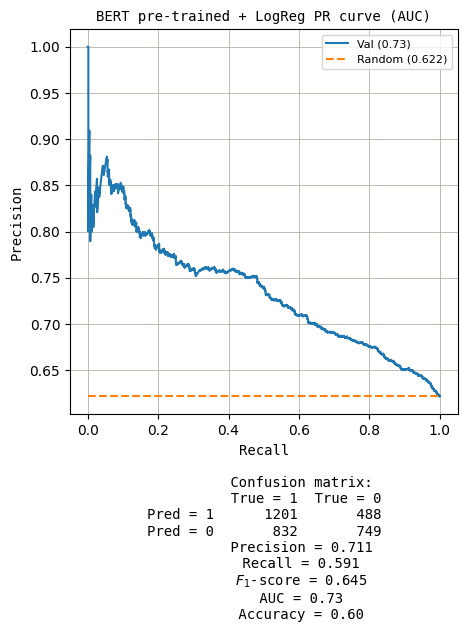

In [58]:
plot_pr_curve(precision_val_bert, recall_val_bert, y_val_bert, y_pred_val_bert, 'BERT pre-trained + LogReg PR curve (AUC)')

The __accuracy of BERT pre-trained + LogReg is higher__ than that of Word2Vec pre-trained + LogReg. Other metrics are also higher.

In [59]:
# Clean up CUDA
del pipe_bert_lr
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj
torch.cuda.empty_cache()
gc.collect()
torch.cuda.is_available()

True

### <a id="fine-bert"></a>[40%] 3. Fine-tune BERT

* 3.1 (10%) Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

In [7]:
# Load data
data = pd.read_json('BoolQ/train.jsonl', lines=True, dtype={'label': np.int64})
val = pd.read_json('BoolQ/val.jsonl', lines=True, dtype={'label': np.int64})

In [8]:
# Stratified split, since target classes are imbalanced
target = 'label'
train, dev = train_test_split(data, test_size=0.1, stratify=data[target], random_state=seed)

In [9]:
train[target].value_counts(normalize=True)

label
1    0.623055
0    0.376945
Name: proportion, dtype: float64

In [10]:
dev[target].value_counts(normalize=True)

label
1    0.623542
0    0.376458
Name: proportion, dtype: float64

In [11]:
val[target].value_counts(normalize=True)

label
1    0.621713
0    0.378287
Name: proportion, dtype: float64

First, let's write a function to prepare our data. We'll use BERT tokenizer for document tokenization.

In [12]:
def prepare_data(model, dataset):
    '''
    Tokenize all sentences in `dataset` Pandas DataFrame and prepare data for DataLoader.
    The first column must me sentences, and the second column must be labels.
    Tokenizer is used from `model`.
    Source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    '''
    sentences = dataset.iloc[:, 0].values
    labels = dataset.iloc[:, 1].values
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_dict = model.tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,    # Add '[CLS]' and '[SEP]' special tokens
                            max_length=model.max_len,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt'
                    )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    prepared = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
    
    return prepared

Next, we will format our questions and passage into concatenated documents by inserting the special token `[SEP]`, just like we did for BERT pre-trained + LogReg in 2.4 above.

In [13]:
train['doc'] = train['question'] + '? [SEP] ' + train['passage']
dev['doc'] = dev['question'] + '? [SEP] ' + dev['passage']
val['doc'] = val['question'] + '? [SEP] ' + val['passage']

Now, let's create a class (model factory) to build models based on some pre-trained ones, but with the untrained last classification layer. The class will also have methods to train and validate models.

> Quick note: We saw that the average length of a question is around 9 tokens, and the average length of a passage is around 97 tokens. So the average length of a document is around 106 tokens. Let's set the `max_length` parameter of BERT tokenizer to 128 (nearest power of 2).

In [14]:
class BoolQClassifier:

    def __init__(self, base_model: str, max_len=128, verbose=False):
        # 1. Create an existing pre-trained model
        if base_model not in ('bert'):
            raise ValueError("base_model should be 'bert'")
        # https://huggingface.co/bert-base-multilingual-cased
        name = 'bert'
        model_str = 'bert-base-multilingual-cased'
        tokenizer_str = 'bert-base-multilingual-cased'
        
        self.name = name
        self.model = BertForSequenceClassification.from_pretrained(model_str, num_labels=2, output_attentions=False, output_hidden_states=False)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_str)
        self.max_len = max_len
        self.is_trained = False
        self.verbose = verbose
        self.model = self.model.to(device)


    def train(self, train_subset, val_subset, optimizer, epochs: int, batch_size: int):
        # 1. Prepare data
        prepared_train = prepare_data(self, train_subset)
        prepared_val = prepare_data(self, val_subset)
        # 2. Create data loaders
        self.train_loader = torch.utils.data.DataLoader(prepared_train, batch_size=batch_size, shuffle=True, num_workers=4)
        self.val_loader = torch.utils.data.DataLoader(prepared_val, batch_size=batch_size, shuffle=False, num_workers=4)
        # 3. Store optimizer
        self.optimizer = optimizer
        # 4. Do train and eval loop for the number of epochs
        self.train_losses, self.val_losses, self.train_accs, self.val_accs = [], [], [], []
        for epoch_i, _ in enumerate(range(epochs), start=1):
            print(f'-------------\nEpoch: {epoch_i:>2}/{epochs}')
            # Train one epoch
            self._train()
            # Eval one epoch
            self._validate()
    

    def _train(self):
        '''
        Train the classifier on all batches of the `train_loader` for one epoch.
        '''
        # 1. Switch to train mode
        self.model.train()
        # 2. Do train loop for all batches for one epoch
        print('\nTraining...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.train_loader) / 10)
        for i, data in tqdm(enumerate(self.train_loader), total=len(self.train_loader)):
            # `data` has 3 tensors, as returned by `prepare_data()`
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            self.optimizer.zero_grad()
            output = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            loss = output.loss
            logits = output.logits
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            losses.append(loss.item())
            acc = torch.mean(logits.argmax(-1) == labels, dtype=float) # normalized accuracy_score (sklearn)
            accs.append(acc.item())
            if self.verbose:
                if i % n_batches_to_show == 0:
                    print(f'Batch: {i:>4}, Train loss: {loss:.2f}, Train accuracy: {acc:.2f}')
        # 3. Keep and report train metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.train_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.train_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Train loss: {epoch_mean_loss:.2f}, Train accuracy: {epoch_mean_acc:.2f}')


    def _validate(self):
        '''
        Validate the classifier on all batches of the `val_loader` for one epoch.
        '''
        # 1. Switch to eval mode
        self.model.eval()
        # 2. Do eval loop
        print('\nEvaluating...')
        losses, accs = [], []
        n_batches_to_show = np.ceil(len(self.val_loader) / 10)
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader), total=len(self.val_loader)):
                # `data` has 3 tensors, as returned by `prepare_data()`
                input_ids = data[0].to(device)
                input_mask = data[1].to(device)
                labels = data[2].to(device)
                output = self.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
                loss = output.loss
                logits = output.logits
                losses.append(loss.item())
                acc = torch.mean(logits.argmax(-1) == labels, dtype=float) # normalized accuracy_score (sklearn)
                accs.append(acc.item())
                if self.verbose:
                    if i % n_batches_to_show == 0:
                        print(f'Batch: {i:>3}, Val loss: {loss:.2f}, Val accuracy: {acc:.2f}')
        # 3. Keep and report val metrics for one epoch
        epoch_mean_loss = np.mean(losses)
        self.val_losses.append(epoch_mean_loss)
        epoch_mean_acc = np.mean(accs)
        self.val_accs.append(np.mean(epoch_mean_acc))
        print(f'Epoch avg: Val loss: {epoch_mean_loss:.2f}, Val accuracy: {epoch_mean_acc:.2f}')

* 3.2   (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

Now, let's write a function to set up training parameters and invoke model training. As per the BERT paper, the optimizer can be Adam with learning rate being one of 5e-5, 4e-5, 3e-5, and 2e-5, and the number of training epochs can be 2, 3, or 4. Authors of the BoolQ paper used batch size of 24, learning rate of 1e-5, and 5 training epochs for BERT model.

Let's choose Adam optimizer with learning rate = 1e-5 and train for 4 epochs with batch size = 24.

In [15]:
def train_model(model, train_subset, val_subset, epochs, batch_size):
    ''' 
    Set up training parameters and invoke model training.
    '''
    if not model.is_trained:
        print(f'Training model `{model.name}`.')
        lr = 1e-5 # 5e-5, 4e-5, 3e-5, 2e-5, 1e-5
        optimizer = torch.optim.Adam(model.model.parameters(), lr=lr)
        model.train(train_subset, val_subset, optimizer, epochs, batch_size)
        model.is_trained = True
        # Save model's state and train/val metrics to disk
        torch.save(model.model.state_dict(), f'./models/{model.name}.pt')
        save_metrics(model.name, train_losses=model.train_losses, val_losses=model.val_losses, train_accs=model.train_accs, val_accs=model.val_accs)
        print('Model successfully trained and saved to disk.')
    else:
        print('Model is already trained.')

In [16]:
# Create directories to store results
try:
    Path('./models').mkdir()
    print('`./models` directory successfully created.')
except Exception as e:
    print(str(e))
try:
    Path('./metrics').mkdir()
    print('`./metrics` directory successfully created.')
except Exception as e:
    print(str(e))

`./models` directory successfully created.
`./metrics` directory successfully created.


In [17]:
# Instantiate our classifier
model_bert_fine = BoolQClassifier(base_model='bert')
load_model(model_bert_fine)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned model `bert` not found. Train/eval the model first.


* 3.3   (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1. 

**Note:** you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

The training loop (with evaluation) is implemented inside the BoolQClassifier class. So, we can proceed to model fine-tuning.

In [18]:
# Train on train, evaluate on dev
train_model(model_bert_fine, train[['doc', target]], dev[['doc', target]], epochs=4, batch_size=24)

Training model `bert`.
-------------
Epoch:  1/4

Training...


100%|██████████| 354/354 [02:05<00:00,  2.82it/s]


Epoch avg: Train loss: 0.66, Train accuracy: 0.62

Evaluating...


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]


Epoch avg: Val loss: 0.62, Val accuracy: 0.67
-------------
Epoch:  2/4

Training...


100%|██████████| 354/354 [02:06<00:00,  2.79it/s]


Epoch avg: Train loss: 0.60, Train accuracy: 0.68

Evaluating...


100%|██████████| 40/40 [00:06<00:00,  5.87it/s]


Epoch avg: Val loss: 0.59, Val accuracy: 0.70
-------------
Epoch:  3/4

Training...


100%|██████████| 354/354 [02:07<00:00,  2.78it/s]


Epoch avg: Train loss: 0.51, Train accuracy: 0.76

Evaluating...


100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


Epoch avg: Val loss: 0.57, Val accuracy: 0.74
-------------
Epoch:  4/4

Training...


100%|██████████| 354/354 [02:07<00:00,  2.77it/s]


Epoch avg: Train loss: 0.41, Train accuracy: 0.83

Evaluating...


100%|██████████| 40/40 [00:06<00:00,  5.88it/s]


Epoch avg: Val loss: 0.62, Val accuracy: 0.73
Model successfully trained and saved to disk.


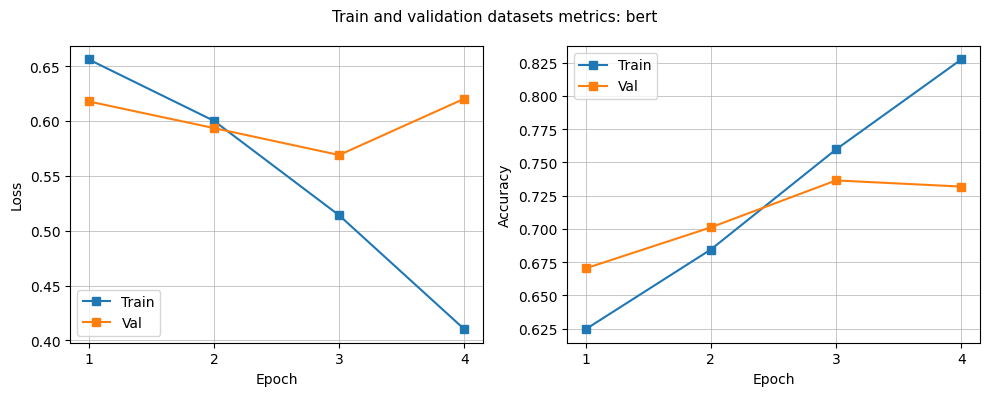

In [19]:
plot_metrics(model_bert_fine.name, epochs=4)

* 3.4   (10%)  Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).

First, let's write a function for model testing.

In [20]:
def test_model(model, test_dataset, batch_size):
    '''
    Predict labels and class probabilities of the `model` on the given `test_dataset` over all batches.
    '''
    # 1. Switch to eval mode
    model.model.eval()
    # 2. Prepare data
    prepared_test = prepare_data(model, test_dataset)
    # 3. Create data loader
    test_loader = torch.utils.data.DataLoader(prepared_test, batch_size=batch_size, shuffle=False, num_workers=4)
    # 4. Do eval loop for all batches
    y_pred_labels = torch.tensor([], dtype=torch.float).to(device)
    y_pred_probas = torch.tensor([], dtype=torch.float).to(device)
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            # `data` has 3 tensors, as returned by `prepare_data()`
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            output = model.model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
            y_pred_label = output.logits.argmax(-1)
            y_pred_labels = torch.cat((y_pred_labels, y_pred_label), dim=0)
            # Convert logits to probabilities
            y_pred_proba = torch.nn.functional.softmax(output.logits, dim=1)
            y_pred_probas = torch.cat((y_pred_probas, y_pred_proba), dim=0)
                    
    return y_pred_labels.cpu().numpy(), y_pred_probas.cpu().numpy()

Compute accuracy and other metrics for `BERT fine-tuned` on val.

In [21]:
# Test on val
y_pred_val_fine, y_pred_proba_val = test_model(model_bert_fine, val[['doc', target]], batch_size=24)

100%|██████████| 137/137 [00:17<00:00,  7.97it/s]


In [22]:
y_val_fine = val[target]

In [23]:
y_pred_proba_class_1_val = y_pred_proba_val[:, 1]
precision_val_fine, recall_val_fine, _ = precision_recall_curve(y_val_fine, y_pred_proba_class_1_val)

In [24]:
bert_fine_acc = accuracy_score(y_val_fine, y_pred_val_fine)
print(f'{bert_fine_acc:.2f}')

0.71


Since target classes are imbalanced, let's also check confusion matrix and metrics for the positive class: precision, recall, f1-score, and AUC.

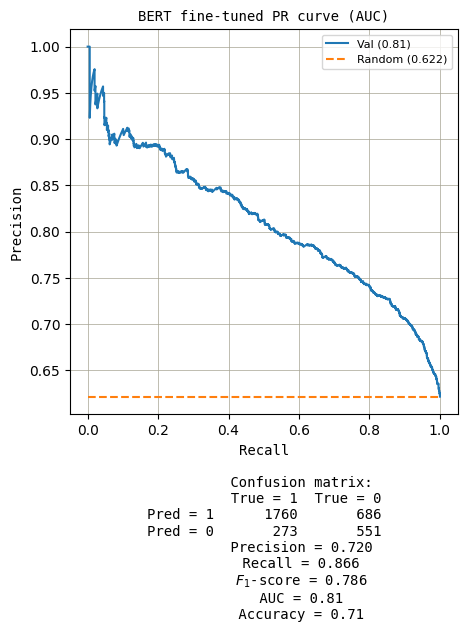

In [25]:
plot_pr_curve(precision_val_fine, recall_val_fine, y_val_fine, y_pred_val_fine, 'BERT fine-tuned PR curve (AUC)')

The __accuracy of BERT fine-tuned is higher__ than that of BERT pre-trained + LogReg. Other metrics are also higher. Our accuracy is comparable with the results demonstrated by the authors of the BoolQ paper.

### <a id="summary"></a>[10%] 4. Summary & results analysis

* 4.1    (5%) Compare the results of all the tested models and try to interpret them.

Finally, let's compare accuracies and other metrics of the three models.

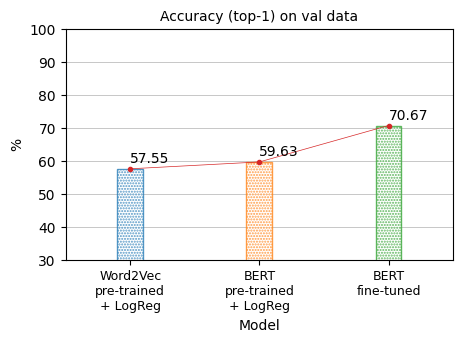

In [60]:
# Plot val accuracy for all models side by side
plt.figure(figsize=(5, 3))
plt.bar(['Word2Vec\npre-trained\n+ LogReg', 'BERT\npre-trained\n+ LogReg', 'BERT\nfine-tuned'], [w2v_lr_acc * 100, bert_lr_acc * 100, bert_fine_acc * 100], color=['white', 'white', 'white'], edgecolor=['C0', 'C1', 'C2'], width=0.2, hatch='.'*6, alpha=0.75)
plt.plot([w2v_lr_acc * 100, bert_lr_acc * 100, bert_fine_acc * 100], marker='.', color='C3', lw=0.5)
plt.text('Word2Vec\npre-trained\n+ LogReg', w2v_lr_acc * 100 + 2, round(w2v_lr_acc * 100, 2))
plt.text('BERT\npre-trained\n+ LogReg', bert_lr_acc * 100 + 2, round(bert_lr_acc * 100, 2))
plt.text('BERT\nfine-tuned', bert_fine_acc * 100 + 2, round(bert_fine_acc * 100, 2))
plt.xlim([-0.5, 2.5])
plt.ylim(30.0, 100.0)
plt.xlabel('Model')
plt.xticks(fontsize=9)
plt.ylabel('%')
plt.title('Accuracy (top-1) on val data', fontsize=10)
plt.grid(axis='y', lw=0.5)
plt.gca().set_axisbelow(True)

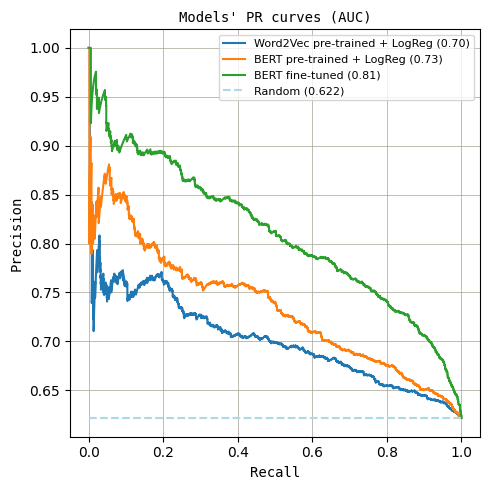

In [61]:
# Plot PR curves for all models side by side
plt.figure(figsize=(5, 5))
plt.plot(recall_val_w2v, precision_val_w2v, color=f'C0', label=f'Word2Vec pre-trained + LogReg ({auc(recall_val_w2v, precision_val_w2v):.2f})')
plt.plot(recall_val_bert, precision_val_bert, color=f'C1', label=f'BERT pre-trained + LogReg ({auc(recall_val_bert, precision_val_bert):.2f})')
plt.plot(recall_val_fine, precision_val_fine, color=f'C2', label=f'BERT fine-tuned ({auc(recall_val_fine, precision_val_fine):.2f})')
plt.hlines(y_val_fine.mean(), xmin=0.0, xmax=1.0, ls='--', color='lightblue', label=f'Random ({y_val_fine.mean():.3f})')
plt.xlabel('Recall', size=10, fontfamily='monospace')
plt.ylabel('Precision', size=10, fontfamily='monospace')
plt.legend(fontsize=8)
plt.grid(lw=0.5, color='xkcd:cement')
plt.title("Models' PR curves (AUC)", size=10, fontfamily='monospace')
plt.tight_layout();

We can clearly see the following:
- BERT fine-tuned (<span style="color:green">green</span>) is the leader. This is quite expected, since we fine-tuned it specifically on our down-stream task data. At the same time, for the first two models, we simply obtained pre-trained embeddings.
- BERT model has a more sophisticated architecture than that of Word2Vec model, thus producing better features for the input document. This is why the BERT pre-trained model (<span style="color:orange">orange</span>) performs better than the Word2Vec pre-trained model (<span style="color:blue">blue</span>), with the same Logistic Regression classifier.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).

- Use more data for training from various contexts and language usage scenarios;
- Tune learning rate. During training / validation two learning rates were tested: 1e-5 and 2e-5, and eventually 1e-5 was chosen as providing better accuracy;
- Tune tokenizer: try to train for longer sentences. We used 128 tokens max, but there are longer passages in the data. BERT maximal sequence length is 512 tokens;
- Try another optimizer, like AdamW, Adagrad, Adadelta, etc. In this assignment only Adam was used;
- Tune the number of training epochs. Though the authors of BoolQ used 5 epochs, in our case 3 or 4 is quite enough, after that the model begins to overfit;
- Try other embeddings techniques. We can clearly see that switching to BERT embeddings helped increase accuracy of the Logistic Regression classifier as compared with Word2Vec embeddings;
- Try other models / architectures. We obtained high-dimensional embeddings: 300 (Word2Vec) and 768 (BERT). Logistic Regression may overfit with large number of features, so we might want to either turn on regularization for LogReg or use another model, for example, Random Forest, which is more robust to overfitting.

* 4.3 It is also interesting to see how our fine-tuned model infers from real unseen data. Let's try to predict the label of some random questions and passages.

In [62]:
# 10 random questions and passages concatenated into documents
qps = ['Is Moscow the capital city of Russia? [SEP] The city of Moscow was founded back in 1147 AD. It is now the capital of Russia.',
        'Did John Smith play in Star Wars? [SEP] George Lucas invited many actors to play in the famous trilogy Star Wars. However, John Smith was not invited.',
        'Are there any palm trees in Vietnam? [SEP] Vietnam is located in hot and humid climate. Palm trees are ubiquitous in areas with hot and humid climate.',
        'Can there be palm trees in Antarctica? [SEP] Palm trees can only grow in areas with hot and humid climate.',
        'Is Earth flat? [SEP] Earth is a planet. No planet can be flat.',
        'Is it possible to breathe under the water with some special equipment? [SEP] You can breathe under the water if you have an aqualung.',
        "Was Xi'an a capital in ancient China? [SEP] Xi'an was the capital city of the Tang dynasty in the 10th century AD.",
        'Does Pangaea still exist? Pangaea or Pangea was a supercontinent that existed during the late Paleozoic and early Mesozoic eras.',
        'Is watermelon a berry? Watermelon is grown in favorable climates worldwide for its large edible fruit, which is a berry ',
        'Is spider an insect? Insects fall under the class Insecta while spiders fall under the Arachnida class.'
        ]
labels = [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]

In [63]:
labels_pred = []
for qp, label in zip(qps, labels):
    labels_pred.append(model_bert_fine.model(**model_bert_fine.tokenizer(qp, return_tensors='pt').to(device)).logits.argmax(-1).item())

In [64]:
labels_pred

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1]

In [65]:
print(f'{accuracy_score(labels, labels_pred):.2f}')

0.80


For the given 10 random question and passages, the accuracy of the BERT fine-tuned model predictions is even higher than that obtained on the val data.

In [66]:
# Clean up CUDA
del model_bert_fine
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj
torch.cuda.empty_cache()
gc.collect()
torch.cuda.is_available()

True

Sources:
- [BoolQ paper](https://arxiv.org/pdf/1905.10044.pdf)
- [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)
- [Natural Language Processing HSE course](https://edu.hse.ru/course/view.php?id=192579)
- [Introduction to Deep Learning HSE course](https://edu.hse.ru/course/view.php?id=182084)
- [Hugging Face - BERT multilingual base model (cased)](https://huggingface.co/bert-base-multilingual-cased)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Provide links to the tutorials you use for reference.
